In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
power_data = pd.read_csv('artifacts/wtbdata_245days.csv')
power_data.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [30]:
class DataCleaner:
    def __init__(self, data):
        self.data = data

    def clean_data(self):
        # Apply all abnormal conditions to filter out invalid data
        conditions = [
            self.data['Patv'] < 0,
            (self.data['Wspd'] < 1) & (self.data['Patv'] > 10),
            (self.data['Wspd'] < 2) & (self.data['Patv'] > 100),
            (self.data['Wspd'] < 3) & (self.data['Patv'] > 200),
            (self.data['Wspd'] > 2.5) & (self.data['Patv'] == 0),
            (self.data['Wspd'] == 0) & (self.data['Wdir'] == 0) & (self.data['Etmp'] == 0),
            self.data['Etmp'] < -21,
            self.data['Itmp'] < -21,
            self.data['Etmp'] > 60,
            self.data['Itmp'] > 70,
            (self.data['Wdir'] > 180) | (self.data['Wdir'] < -180),
            (self.data['Ndir'] > 720) | (self.data['Ndir'] < -720),
            (self.data['Pab1'] > 89) | (self.data['Pab2'] > 89) | (self.data['Pab3'] > 89)
        ]
        
        # Combine all conditions with OR operator
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition |= condition
        
        # Filter out rows that meet any of the abnormal conditions
        self.data = self.data[~combined_condition]

        self.data = self.data.dropna()
        return self.data

# Create an instance of the DataCleaner class and clean the data
cleaner = DataCleaner(power_data)
cleaned_data = cleaner.clean_data()


cleaned_data = cleaned_data[6000:10000]
# Display the first few rows of the cleaned dataframe to verify the data is cleaned correctly
cleaned_data.head()

train, test = train_test_split(cleaned_data, test_size=0.5, random_state=42)
train

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
11097,1,78,01:30,3.19,1.74,31.47,40.79,-29.63,0.99,0.99,0.99,-0.25,129.64
7945,1,56,04:10,9.58,-4.62,30.39,43.09,8.20,1.00,1.00,1.00,-0.24,1237.39
8319,1,58,18:30,7.12,0.09,28.94,39.14,244.08,1.00,1.00,1.00,-0.24,762.42
10070,1,70,22:20,5.99,2.29,35.31,43.90,303.76,1.00,1.00,1.00,-0.24,439.01
8993,1,63,10:50,5.75,0.67,33.88,43.66,75.57,0.99,0.99,0.99,-0.26,437.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9117,1,64,07:30,7.42,2.84,31.09,38.78,39.67,1.00,1.00,1.00,-0.27,668.30
9305,1,65,14:50,5.66,3.42,39.05,48.34,19.73,1.09,1.09,1.08,-0.02,314.80
8589,1,60,15:30,8.62,3.29,38.04,49.27,416.92,1.00,1.00,1.00,-0.31,1061.76
12328,1,86,14:40,6.71,1.91,34.70,44.53,223.51,1.00,1.00,1.00,-0.21,688.53


In [38]:
# encode Tmstamp column to numeric values
train['Tmstamp'] = pd.to_datetime(train['Tmstamp']).astype(int) // 10**9
test['Tmstamp'] = pd.to_datetime(test['Tmstamp']).astype(int) // 10**9

/var/folders/pw/7hr2k18x7713lgrp51kl_3080000gn/T/ipykernel_78846/3317315984.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test['Tmstamp'] = pd.to_datetime(test['Tmstamp']).astype(int) // 10**9


<Axes: >

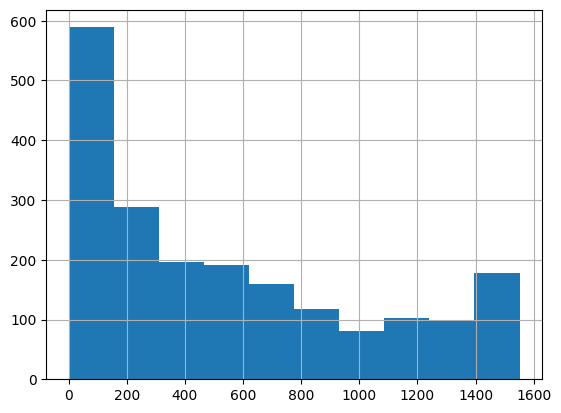

In [32]:
train["Patv"].hist()

In [39]:
# Split the data into training and testing sets
X = train.drop(columns=['Patv'])
y = train['Patv']

X_test = test.drop(columns=['Patv'])
y_test = test['Patv']

# Train an XGBoost model 
model = XGBRegressor()
model.fit(X, y)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error and mean absolute error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 1409.2430257025057
Mean Absolute Error: 21.367525075126117


### GAN synthesized data

In [40]:
subset_power_data = cleaned_data
subset_power_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
7608,1,53,20:00,7.96,3.38,34.93,45.50,212.74,1.00,1.00,1.00,-0.23,886.17
7609,1,53,20:10,8.97,-1.94,34.90,45.54,207.82,1.00,1.00,1.00,-0.21,1071.01
7610,1,53,20:20,8.98,5.65,34.85,45.58,220.33,1.00,1.00,1.00,-0.20,1143.00
7611,1,53,20:30,8.12,1.19,34.52,45.49,251.20,1.00,1.00,1.00,-0.20,931.46
7612,1,53,20:40,5.89,-1.71,34.24,45.46,249.54,0.99,0.99,0.99,-0.24,441.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12956,1,90,23:20,1.71,4.80,35.16,43.41,211.93,0.99,0.99,0.99,-0.21,32.48
12957,1,90,23:30,2.27,8.68,35.09,43.53,227.06,0.99,0.99,0.99,-0.21,54.39
12958,1,90,23:40,2.95,8.55,34.87,43.40,284.04,0.99,0.99,0.99,-0.20,93.57
12959,1,90,23:50,3.09,2.84,34.79,43.02,290.69,0.99,0.99,0.99,-0.21,109.11


<Axes: >

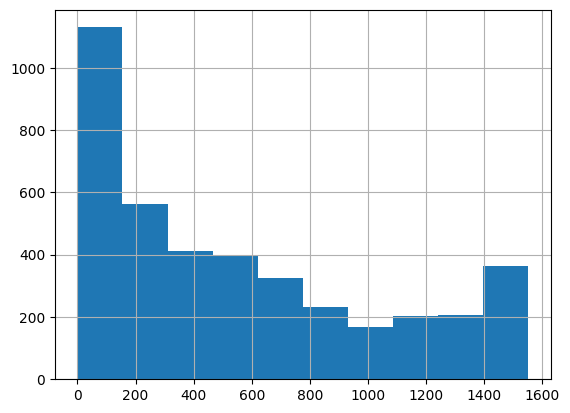

In [41]:
subset_power_data["Patv"].hist()

In [42]:
from synthetic_energy.time_series import DGAN, DGANConfig

features = subset_power_data.to_numpy()#.drop(columns="Patv").to_numpy()
n_time_points = 2
n = features.shape[0] // n_time_points
features = features[: n * n_time_points, :].reshape(
    -1, n_time_points, features.shape[1]
)

config = DGANConfig(max_sequence_len=20, sample_len=5, batch_size=10, epochs=10, cuda=False)
dg = DGAN(config=config)

dg.train_numpy(
    features=features,
)

attributes, features = dg.generate_numpy(n=100)

print(features[0])

2024-12-03 23:21:44 [info     ] Training DGAN model            dtype=dtype('O') features_length=2000 first_sequence_shape=(2, 13)
2024-12-03 23:21:44 [info     ] Determining outputs metadata from input data
2024-12-03 23:21:44 [info     ] Building DGAN networks        
2024-12-03 23:21:44 [info     ] Checking for nans in the numeric columns number_of_columns=12
2024-12-03 23:21:45 [info     ] Applying linear interpolations for nans (does not mean nans are present)
2024-12-03 23:21:45 [info     ] Creating encoded array of features
2024-12-03 23:21:45 [info     ] Creating encoded array of attributes
2024-12-03 23:21:45 [info     ] Training...                    dtype=dtype('float32') internal_additional_attributes_shape=(2000, 24) internal_attributes_shape=(2000, 1) internal_features_shape=(2000, 20, 156)
2024-12-03 23:21:45 [info     ] Creating TensorDataset        
2024-12-03 23:21:45 [info     ] Calling _train()              
2024-12-03 23:21:45 [info     ] Training                   

/Users/infraspeak/anaconda3/envs/icsp/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


2024-12-03 23:21:58 [info     ] Training                       epoch=1
2024-12-03 23:22:11 [info     ] Training                       epoch=2
2024-12-03 23:22:23 [info     ] Training                       epoch=3
2024-12-03 23:22:34 [info     ] Training                       epoch=4
2024-12-03 23:22:46 [info     ] Training                       epoch=5
2024-12-03 23:22:59 [info     ] Training                       epoch=6
2024-12-03 23:23:11 [info     ] Training                       epoch=7
2024-12-03 23:23:28 [info     ] Training                       epoch=8
2024-12-03 23:23:43 [info     ] Training                       epoch=9
[[1.0 81.97665405273438 '19:30' 7.997675895690918 -15.019927978515625
  32.82181167602539 39.755889892578125 214.76712036132812
  0.9881408214569092 0.9884555339813232 0.9922645092010498
  -0.27282238006591797 345.2734680175781]
 [1.0 81.97667694091797 '22:20' 8.14272403717041 -14.977279663085938
  32.819522857666016 39.748390197753906 214.29898071289062
  0.

In [43]:
import numpy as np
import pandas as pd

# Define the column names
columns = ["TurbID", "Day", "Tmstamp", "Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Pab1", "Pab2", "Pab3", "Prtv", "Patv"]

# Convert the generated list to a NumPy array
features_array = np.array(features)

# Reshape the array and convert it to a DataFrame
synthetic_df = pd.DataFrame(features_array.reshape(-1, features_array.shape[-1]), columns=columns)

synthetic_df

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1.0,81.976654,19:30,7.997676,-15.019928,32.821812,39.75589,214.76712,0.988141,0.988456,0.992265,-0.272822,345.273468
1,1.0,81.976677,22:20,8.142724,-14.97728,32.819523,39.74839,214.298981,0.987947,0.988301,0.992229,-0.276833,354.650452
2,1.0,81.976654,19:00,7.991477,-15.037476,32.819523,39.74839,214.261566,0.987948,0.988302,0.992229,-0.278199,344.888824
3,1.0,81.976654,00:00,7.991474,-15.03746,32.819523,39.74839,214.261749,0.987947,0.988301,0.992229,-0.278198,344.888458
4,1.0,81.976654,20:40,7.991475,-15.037476,32.819523,39.74839,214.261566,0.987947,0.988301,0.992229,-0.278199,344.888916
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.0,74.358582,14:30,2.586208,2.169449,32.944672,39.272652,375.264801,1.007735,0.989797,1.078937,-0.250814,17.821009
1996,1.0,74.358597,10:10,2.58572,2.168823,32.944668,39.272633,375.262054,1.007736,0.989797,1.078938,-0.250786,17.695148
1997,1.0,74.358582,09:10,2.585734,2.168701,32.944668,39.272633,375.262054,1.007738,0.989799,1.078939,-0.250813,17.697678
1998,1.0,74.358589,18:30,2.585728,2.168823,32.944668,39.272633,375.262299,1.007737,0.989798,1.078939,-0.250812,17.697025


<Axes: >

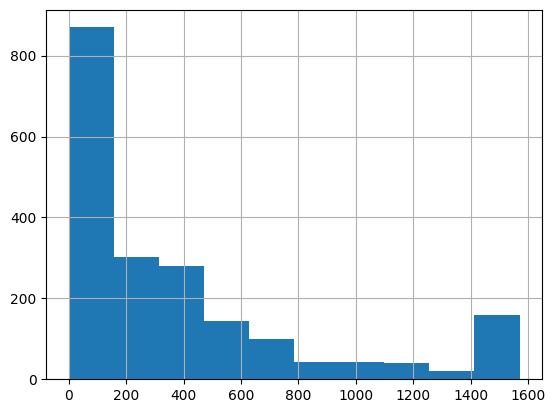

In [44]:
synthetic_df["Patv"].hist()

<Axes: >

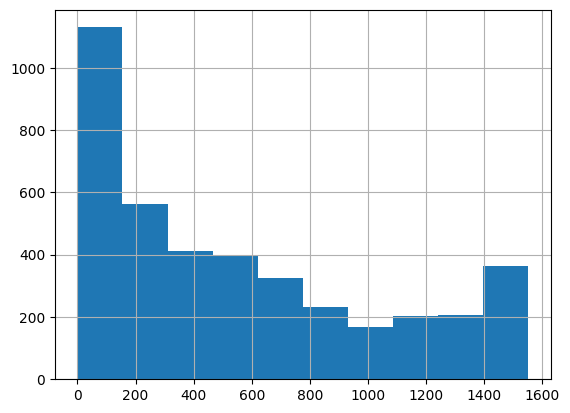

In [45]:
subset_power_data["Patv"].hist()

In [46]:
# Create an instance of the DataCleaner class and clean the data
cleaner = DataCleaner(synthetic_df)
synthesized_cleaned_data = cleaner.clean_data()

# Display the first few rows of the cleaned dataframe to verify the data is cleaned correctly
synthesized_cleaned_data.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1.0,81.976654,19:30,7.997676,-15.019928,32.821812,39.75589,214.76712,0.988141,0.988456,0.992265,-0.272822,345.273468
1,1.0,81.976677,22:20,8.142724,-14.97728,32.819523,39.74839,214.298981,0.987947,0.988301,0.992229,-0.276833,354.650452
2,1.0,81.976654,19:00,7.991477,-15.037476,32.819523,39.74839,214.261566,0.987948,0.988302,0.992229,-0.278199,344.888824
3,1.0,81.976654,00:00,7.991474,-15.03746,32.819523,39.74839,214.261749,0.987947,0.988301,0.992229,-0.278198,344.888458
4,1.0,81.976654,20:40,7.991475,-15.037476,32.819523,39.74839,214.261566,0.987947,0.988301,0.992229,-0.278199,344.888916


In [ ]:
# Split the data into training and testing sets
X = synthesized_cleaned_data.drop(columns=['Patv'])
y = synthesized_cleaned_data['Patv']


# Train an XGBoost model 
model = XGBRegressor()
model.fit(X, y)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error and mean absolute error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

ValueError: feature_names mismatch: ['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv'] ['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']
training data did not have the following fields: Patv

In [15]:
synthetic_df

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1.0,61.739124,1.733230e+09,1.335371,-17.690308,35.653873,43.065670,91.361626,1.558140,1.560022,1.757392,-0.182970,3.731155
1,1.0,61.739906,1.733230e+09,1.385709,-17.171249,35.623562,43.019562,90.530800,1.560337,1.563413,1.759650,-0.181726,25.337555
2,1.0,61.739353,1.733230e+09,1.323730,-17.680328,35.624573,43.020817,90.530319,1.558205,1.560137,1.757450,-0.182943,-2.456862
3,1.0,61.739265,1.733230e+09,1.327390,-17.675400,35.624802,43.020866,90.559822,1.558233,1.560097,1.757461,-0.182926,-2.310853
4,1.0,61.739559,1.733230e+09,1.324000,-17.682236,35.624184,43.020607,90.502907,1.558217,1.560164,1.757455,-0.182924,-2.759390
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.0,55.625931,1.733189e+09,7.359435,-12.283920,26.911400,36.534710,397.943604,0.993333,0.995244,0.997028,-0.294415,555.984863
1996,1.0,55.625931,1.733189e+09,7.359554,-12.283997,26.911312,36.534798,397.942596,0.993333,0.995244,0.997028,-0.294415,555.930847
1997,1.0,55.625931,1.733189e+09,7.359293,-12.284897,26.911301,36.534607,397.942383,0.993334,0.995244,0.997028,-0.294419,555.808472
1998,1.0,55.625931,1.733189e+09,7.359327,-12.284897,26.911306,36.534618,397.942291,0.993334,0.995244,0.997028,-0.294419,555.788269


In [16]:
from synthetic_energy.quality_metrics import (
    WassersteinDistance,
    KLDivergence,
    PopulationStabilityIndex
)
from sklearn.preprocessing import MinMaxScaler

# Defines a small constant to avoid zero probabilities
epsilon = 1e-10
original_data = subset_power_data.values + epsilon
synthetic_data = synthetic_df.values + epsilon

# Normalize the data
scaler = MinMaxScaler()
original_data_normalized = scaler.fit_transform(original_data)
synthetic_data_normalized = scaler.transform(synthetic_data)

# Calculate the Wasserstein distance between the original and synthetic data
wd = WassersteinDistance()
wd_value = wd._distance(original_data_normalized, synthetic_data_normalized)
print(f'Wasserstein Distance: {wd_value}')

# Calculate the Kullback-Leibler divergence between the original and synthetic data
kl = KLDivergence()
kl_value = kl._distance(original_data_normalized, synthetic_data_normalized)
print(f'KL Divergence: {kl_value}')

# Calculate the Population Stability Index between the original and synthetic data
psi = PopulationStabilityIndex()
psi_value = psi._distance(original_data_normalized, synthetic_data_normalized)
print(f'Population Stability Index: {psi_value}')


Wasserstein Distance: 231.12174672696358
KL Divergence: inf
Population Stability Index: inf


In [17]:
synthetic_df.shape

(2000, 13)

In [18]:
subset_power_data.shape

(2000, 13)

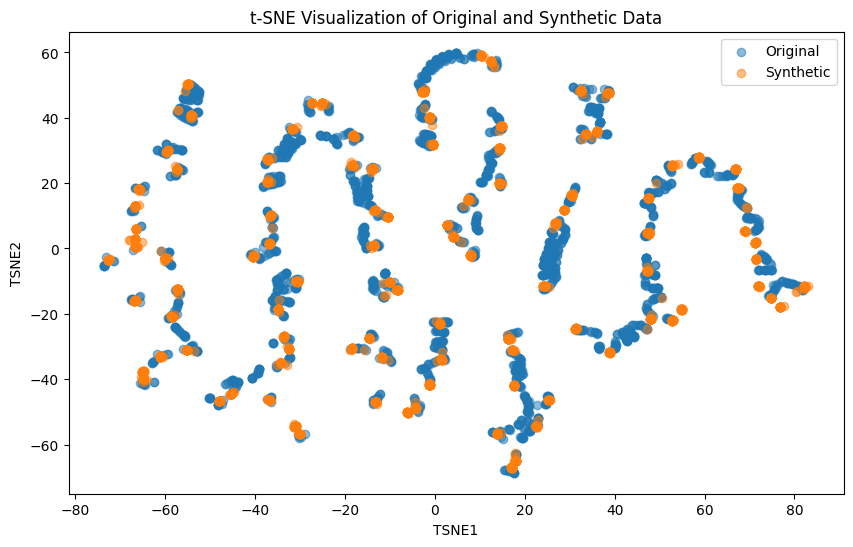

In [19]:
from sklearn.manifold import TSNE

# Combine the original and synthetic data for t-SNE visualization
combined_data = np.vstack((subset_power_data.values, synthetic_df.values))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_data)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = ['Original'] * len(subset_power_data) + ['Synthetic'] * len(synthetic_df)

# Plot the results
plt.figure(figsize=(10, 6))
for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['TSNE1'], subset['TSNE2'], label=label, alpha=0.5)
plt.legend()
plt.title('t-SNE Visualization of Original and Synthetic Data')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

In [22]:
subset_power_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
7608,1,53,1733256000,7.96,3.38,34.93,45.50,212.74,1.00,1.00,1.00,-0.23,886.17
7609,1,53,1733256600,8.97,-1.94,34.90,45.54,207.82,1.00,1.00,1.00,-0.21,1071.01
7610,1,53,1733257200,8.98,5.65,34.85,45.58,220.33,1.00,1.00,1.00,-0.20,1143.00
7611,1,53,1733257800,8.12,1.19,34.52,45.49,251.20,1.00,1.00,1.00,-0.20,931.46
7612,1,53,1733258400,5.89,-1.71,34.24,45.46,249.54,0.99,0.99,0.99,-0.24,441.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10404,1,73,1733205600,9.23,-1.96,28.05,39.90,56.77,1.00,1.00,1.00,-0.23,1214.99
10405,1,73,1733206200,8.56,-3.58,27.97,39.90,56.77,1.00,1.00,1.00,-0.20,1046.70
10406,1,73,1733206800,8.05,-0.93,27.90,39.95,50.31,1.00,1.00,1.00,-0.27,905.51
10407,1,73,1733207400,8.20,3.37,27.90,40.08,49.12,1.00,1.00,1.00,-0.23,921.66
